## 1. Data preprocessing [7 marks]

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#Set floating point output precision
pd.set_option('precision', 8)
df = pd.read_csv('./data/train.csv', encoding= 'unicode_escape')

In [2]:
#Change all '?' in the table to 'NaN'
df = df.replace(['?'], np.NaN)

#View the number of missing values for each descriptive variables, which will 
#be referred to when selecting the categorical variables later.
df.isnull().sum()

Row_ID                0
Household_ID          0
Vehicle               0
Calendar_Year         0
Model_Year            0
Blind_Make           15
Blind_Model          15
Blind_Submodel       15
Cat1                 50
Cat2              10591
Cat3                 11
Cat4              12985
Cat5              12998
Cat6                 50
Cat7              16480
Cat8                  2
Cat9                  0
Cat10                10
Cat11                58
Cat12                52
OrdCat               19
Var1                  0
Var2                  0
Var3                  0
Var4                  0
Var5                  0
Var6                  0
Var7                  0
Var8                  0
NVCat                 0
NVVar1                0
NVVar2                0
NVVar3                0
NVVar4                0
Claim_Amount          0
dtype: int64

In [3]:
#View how many elements are in each categorical variables, which will 
#be referred to when selecting the categorical variables later.

print('cat1', df.loc[:, 'Cat1'].unique())
print('cat2', df.loc[:, 'Cat2'].unique())
print('cat3', df.loc[:, 'Cat3'].unique())
print('cat4', df.loc[:, 'Cat4'].unique())
print('cat5', df.loc[:, 'Cat5'].unique())
print('cat6', df.loc[:, 'Cat6'].unique())
print('cat7', df.loc[:, 'Cat7'].unique())
print('cat8', df.loc[:, 'Cat8'].unique())
print('cat9', df.loc[:, 'Cat9'].unique())
print('cat10', df.loc[:, 'Cat10'].unique())
print('cat11', df.loc[:, 'Cat11'].unique())
print('cat12', df.loc[:, 'Cat12'].unique())
print('ordcat', df.loc[:, 'OrdCat'].unique())
print('nvcat', df.loc[:, 'NVCat'].unique())

cat1 ['B' 'F' 'I' 'A' 'D' 'G' 'H' 'C' 'J' 'E' nan]
cat2 [nan 'C' 'A' 'B']
cat3 ['A' 'B' 'E' 'C' 'F' 'D' nan]
cat4 ['A' 'C' nan 'B']
cat5 ['A' nan 'C' 'B']
cat6 ['C' 'D' 'E' 'F' 'B' nan]
cat7 ['C' 'D' nan 'A' 'B']
cat8 ['B' 'A' 'C' nan]
cat9 ['B' 'A']
cat10 ['B' 'A' 'C' nan]
cat11 ['F' 'B' 'A' 'D' 'E' 'C' nan]
cat12 ['B' 'D' 'C' 'E' 'F' nan 'A']
ordcat ['2' '5' '4' nan '1' '7' '3' '6']
nvcat ['N' 'F' 'M' 'B' 'O' 'L' 'J' 'K' 'H' 'E' 'C' 'A' 'G' 'I' 'D']


### 1.a. The dataset has several fields with missing data. Choose a method to deal with missing data and justify your choice [2 marks]

### answer:  
The missing values of categorical variables cannot be filled in with the mean or median value. I use the mode to fill in here. This is more robust to categorical variables with fewer outliers. For categorical variables with a large number of outliers, I will directly drop them later.

Numerical variables have no missing values, only a small amount of '0', and according to the data dictionary, the mean values of Var1-8 and NVVar1-4 are all '0', so there is no need to deal with missing values for numerical variables.


In [4]:
#Filling missing values of categorical variables with mode
df.Blind_Make.fillna(df.Blind_Make.mode()[0], inplace=True)
df.Blind_Model.fillna(df.Blind_Model.mode()[0], inplace=True)
df.Blind_Submodel.fillna(df.Blind_Submodel.mode()[0], inplace=True)
df.Cat1.fillna(df.Cat1.mode()[0], inplace=True)
df.Cat2.fillna(df.Cat2.mode()[0], inplace=True)
df.Cat3.fillna(df.Cat3.mode()[0], inplace=True)
df.Cat4.fillna(df.Cat4.mode()[0], inplace=True)
df.Cat5.fillna(df.Cat5.mode()[0], inplace=True)
df.Cat6.fillna(df.Cat6.mode()[0], inplace=True)
df.Cat7.fillna(df.Cat7.mode()[0], inplace=True)
df.Cat8.fillna(df.Cat8.mode()[0], inplace=True)
df.Cat10.fillna(df.Cat10.mode()[0], inplace=True)
df.Cat11.fillna(df.Cat11.mode()[0], inplace=True)
df.Cat12.fillna(df.Cat12.mode()[0], inplace=True)
df.OrdCat.fillna(df.OrdCat.mode()[0], inplace=True)

Since the origin set with more than 30000 instances will cause the 'fit' process of gradient boosting classifier to be extremly slow on my computer(I did not find a solution to this problem), I decided to take 3000 instances of it, and then partition the data into train, validation and test sets.

In [5]:
df = df.sample(3000, random_state = 7)
ca_train_val_set, ca_test_set = train_test_split(df, test_size=0.15, random_state = 7)
ca_train_set_old, ca_val_set = train_test_split(ca_train_val_set, test_size=0.15, random_state = 7)
#view information of unprocessed train set
print(ca_train_set_old.info())
#Unify the data types of numerical variables
for col in ['Row_ID', 'Household_ID', 'Vehicle', 'Calendar_Year', 'Model_Year']:
    ca_train_set_old[col] = ca_train_set_old[col].astype('float64')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 21978 to 26041
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row_ID          2167 non-null   int64  
 1   Household_ID    2167 non-null   int64  
 2   Vehicle         2167 non-null   int64  
 3   Calendar_Year   2167 non-null   int64  
 4   Model_Year      2167 non-null   int64  
 5   Blind_Make      2167 non-null   object 
 6   Blind_Model     2167 non-null   object 
 7   Blind_Submodel  2167 non-null   object 
 8   Cat1            2167 non-null   object 
 9   Cat2            2167 non-null   object 
 10  Cat3            2167 non-null   object 
 11  Cat4            2167 non-null   object 
 12  Cat5            2167 non-null   object 
 13  Cat6            2167 non-null   object 
 14  Cat7            2167 non-null   object 
 15  Cat8            2167 non-null   object 
 16  Cat9            2167 non-null   object 
 17  Cat10           2167 non-nul

<ipython-input-5-f9346a167921>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_train_set_old[col] = ca_train_set_old[col].astype('float64')


### 1.b. Convert categorical values to a suitable representation. Notice that there are many categorical variables in the dataset. If you use all the categorical variables you will end up with a large feature space. Feel free to ignore categorical variables that will increase your feature space considerably but use at least five categorical variables [2 marks].

### answer:  
According to the number of missing values and elements for each categorical variables, I retain Cat3, Cat6, Cat8, Cat9, Cat10 and drop other categorical variables. Later, I will use one-hot encoding for these categorical variables.


In [6]:
#Retain Cat3, Cat6, Cat8, Cat9, Cat10 and drop other categorical variables that will increase the feature space considerably.
ca_train_set_old = ca_train_set_old.drop(['Blind_Make', 'Blind_Model', 'Blind_Submodel', 'Cat1', 'Cat2', 'Cat4',
                                          'Cat5', 'Cat7', 'Cat11', 'Cat12', 'OrdCat', 'NVCat'], axis=1)

### 1.c. The data is highly imbalanced: more records contain zero claims than not. When designing your predictive model, you need to account for this [3 marks].

### answer:  
In order to balance the data of the train set, I made a series of adjustments to make the number of instances with non-zero claims equal to the number of instances with zero claims.

In [7]:
#First checking the number of the instances with zero and non-zero claims.
print('The number of the instances with zero claim in ca_train_set_old is:', (ca_train_set_old['Claim_Amount'] == 0).sum())
print('The number of the instances with non-zero claim in ca_train_set_old is:', (ca_train_set_old['Claim_Amount'] != 0).sum())

#Divide the train set into two subsets according to whether the claims are zero,
#named 'ca_train_set_minor' and 'ca_train_set_major' respectively.
ca_train_set_minor = ca_train_set_old.loc[ca_train_set_old['Claim_Amount'] != 0]
ca_train_set_major = ca_train_set_old.loc[ca_train_set_old['Claim_Amount'] == 0]

#Copy two copies of 'ca_train_set_minor' as a new 'ca_train_set_minor'
ca_train_set_minor = pd.concat([ca_train_set_minor, ca_train_set_minor], axis=0, ignore_index=True)

#Sample the 'ca_train_set_major' to make the number of instances with zero claims equal to those with non-zero claims.
ca_train_set_major = ca_train_set_major.sample(1258, random_state = 7)

#Concatenate two new sets to get the final train set 'ca_train_set'.
ca_train_set = pd.concat([ca_train_set_minor, ca_train_set_major], axis=0, ignore_index=True)

#Check the number of the instances with zero and non-zero claims in train set.
print('The number of the instances with zero claim in ca_train_set is:', (ca_train_set['Claim_Amount'] == 0).sum())
print('The number of the instances with non-zero claim in ca_train_set is:', (ca_train_set['Claim_Amount'] != 0).sum())

The number of the instances with zero claim in ca_train_set_old is: 1538
The number of the instances with non-zero claim in ca_train_set_old is: 629
The number of the instances with zero claim in ca_train_set is: 1258
The number of the instances with non-zero claim in ca_train_set is: 1258


#### The following is the exploration , preparetion and additional steps of data preprocessing

In [8]:
ca_train_set.describe()

,Row_ID,Household_ID,Vehicle,Calendar_Year,Model_Year,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
count,2.51600000e+03,2.51600000e+03,2516.00000000,2516.00000000,2516.00000000,2516.00000000,2516.00000000,2516.00000000,2516.00000000,2516.00000000,2516.00000000,2516.00000000,2516.00000000,2516.00000000,2516.00000000,2516.00000000,2516.00000000,2516.00000000
mean,5.20202437e+06,3.36944891e+06,1.84658188,2006.11406995,1999.25357711,-0.03258372,-0.11964735,-0.05995278,-0.10557680,-0.01007270,-0.09739107,-0.05470683,-0.12957243,-0.00821780,0.12785319,0.14010916,0.04887782,94.96297933
std,3.02402813e+06,1.93748706e+06,1.14422756,0.81298163,5.05713746,0.94342699,0.94013490,1.00511373,0.93536526,0.95369049,0.93205271,0.97123417,0.88368515,0.95896031,1.19181896,1.25830439,1.11935808,415.57967959
min,2.80800000e+03,1.81600000e+03,1.00000000,2005.00000000,1981.00000000,-2.03987810,-2.38964580,-2.32752850,-2.35599300,-3.01135710,-2.18833350,-1.59887970,-1.73979770,-0.23152990,-0.26611680,-0.27233720,-0.25141890,0.00000000
25%,2.70967825e+06,1.93044800e+06,1.00000000,2005.00000000,1996.00000000,-0.66589710,-0.81615190,-0.93910840,-0.78301890,-0.65628810,-0.71362133,-0.89848570,-0.69363840,-0.23152990,-0.26611680,-0.27233720,-0.25141890,0.00000000
50%,4.96967800e+06,3.12725300e+06,1.00000000,2006.00000000,2000.00000000,-0.32039300,-0.17637960,-0.26803870,-0.12338460,-0.11509810,-0.27351785,-0.49299450,-0.29787930,-0.23152990,-0.26611680,-0.27233720,-0.25141890,0.00510763
75%,7.82387300e+06,4.98044400e+06,2.00000000,2007.00000000,2003.00000000,0.38668500,0.39422810,0.61707908,0.40094010,0.52719340,0.41017775,0.78491730,0.23486803,-0.23152990,-0.26611680,-0.27233720,-0.25141890,52.24023000
max,1.04788250e+07,6.47293600e+06,10.00000000,2007.00000000,2008.00000000,3.55246620,3.50663380,4.96167660,3.58071570,3.25098510,3.58301660,2.54204610,6.19080830,6.62711000,8.88308140,8.69114400,6.38880250,11440.75000000


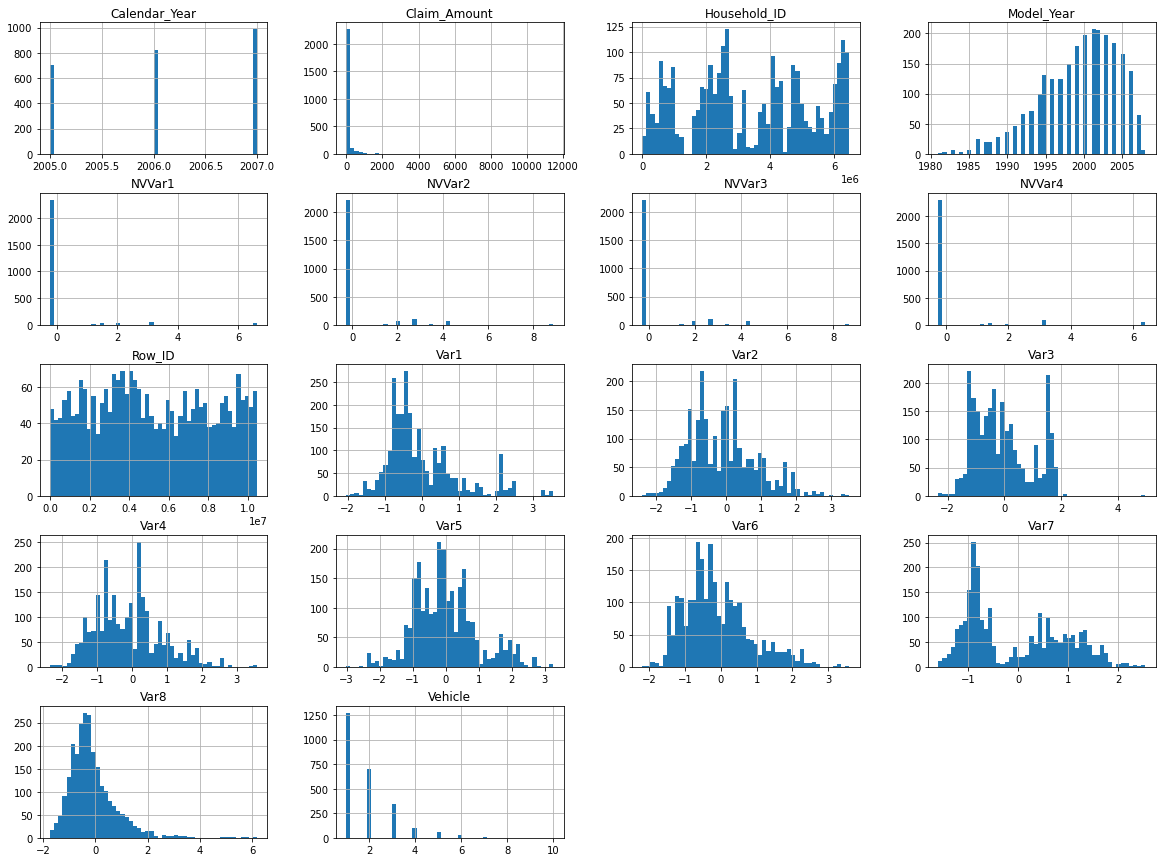

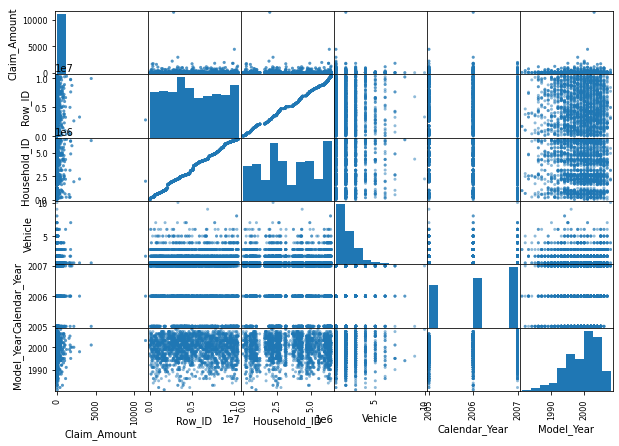

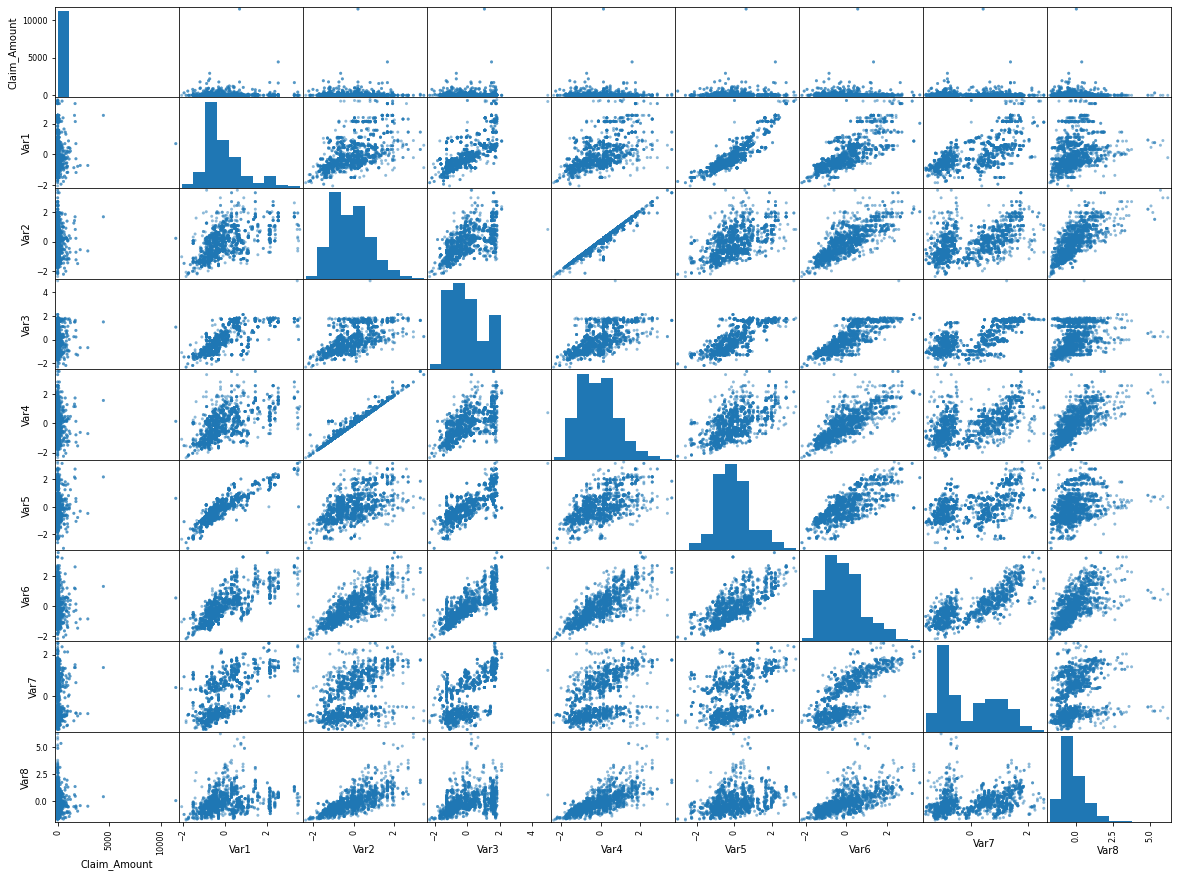

Claim_Amount     1.00000000
Var3             0.04416578
Var5             0.04053085
Var1             0.03499815
Var6             0.01906996
Var7             0.01233501
Var2             0.01194308
Var4             0.00999117
Model_Year       0.00767515
NVVar3           0.00434205
Vehicle          0.00103595
Var8            -0.00146726
Household_ID    -0.00387165
Row_ID          -0.00507275
NVVar1          -0.01473911
Calendar_Year   -0.02130042
NVVar2          -0.02689489
NVVar4          -0.03009144
Name: Claim_Amount, dtype: float64


In [9]:
%matplotlib inline 
#look at histograms for each of the numerical variables
ca_train_set.hist(bins=50, figsize=(20,15))
plt.show()
#look at the scatter plot for the target variable and five of the variables.
attributes = ['Claim_Amount', 'Row_ID', 'Household_ID', 'Vehicle', 'Calendar_Year', 'Model_Year']
figscat = scatter_matrix(ca_train_set[attributes], figsize=(10, 7))
plt.show()
#look at the scatter plot for the target variable and Var1-Var8.
attributes = ['Claim_Amount', 'Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8']
figscat = scatter_matrix(ca_train_set[attributes], figsize=(20, 15))
plt.show()
#Study the correlation coefficient between the numerical variables and the Claim_Amount.
corr_matrix = ca_train_set.corr()
print(corr_matrix['Claim_Amount'].sort_values(ascending=False))

1. The histograms indicates that the variables NVVar1-4, Row_ID, Household_ID, Vehicle and Calendar_Year are concentrated at one of the ends of the plots. This is an indication that several instances might contain outliers.

2. Var1-7 are skewed to the right, considering transforming these features using $\sqrt{x}$ so that they look more like a bell-shaped distribution. 

3. Scatter plot and correlation coefficient are used to explore dependencies between the different variables.

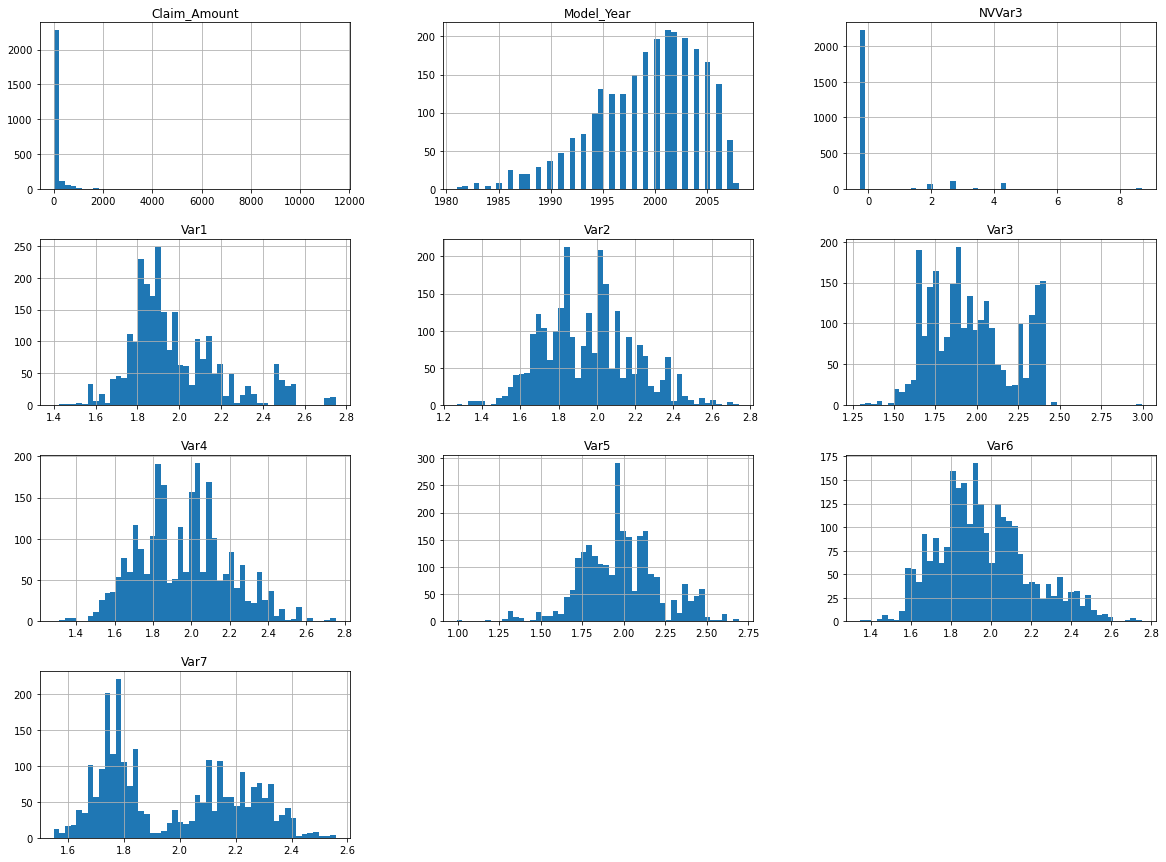

In [10]:
#According to scatter plots, histograms and correlation covariance calculation，I drop 
#NVVar1,2,4, Var8，calen calendar, Row_ID, Household_ID, Vehicle
ca_train_set = ca_train_set.drop(['NVVar1', 'NVVar2', 'NVVar4', 'Var8', 'Calendar_Year',
                                 'Row_ID', 'Household_ID', 'Vehicle'], axis=1)
#transforming Var1-7 using sqrt
ca_train_set['Var1'] = np.sqrt(ca_train_set['Var1'] + 4)  
ca_train_set['Var2'] = np.sqrt(ca_train_set['Var2'] + 4)
ca_train_set['Var3'] = np.sqrt(ca_train_set['Var3'] + 4)
ca_train_set['Var4'] = np.sqrt(ca_train_set['Var4'] + 4)
ca_train_set['Var5'] = np.sqrt(ca_train_set['Var5'] + 4)
ca_train_set['Var6'] = np.sqrt(ca_train_set['Var6'] + 4)
ca_train_set['Var7'] = np.sqrt(ca_train_set['Var7'] + 4)
ca_train_set.hist(bins=50, figsize=(20,15))
plt.show()

In [11]:
#Prepare the data so that it is suitable for the machine learning models. 
#Using one-hot-encoding for the categorical attributes and feature scaling for the numerical attributes.
attri_num = ['Model_Year', 'Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'NVVar3']   
attri_cat = ['Cat3', 'Cat6', 'Cat8', 'Cat9', 'Cat10']
partial_transform = ColumnTransformer([
    ("num", StandardScaler(), attri_num),
    ("cat", OneHotEncoder(handle_unknown = "ignore"), attri_cat),
])

ca_train_set_attri = ca_train_set.drop('Claim_Amount', axis=1)
ca_train_set_labels = ca_train_set['Claim_Amount']
ca_val_set_attri = ca_val_set.drop('Claim_Amount', axis=1)
ca_val_set_labels = ca_val_set['Claim_Amount']
ca_test_set_attri = ca_test_set.drop('Claim_Amount', axis=1)
ca_test_set_labels = ca_test_set['Claim_Amount']

ca_train_set_attri_prepared = partial_transform.fit_transform(ca_train_set_attri)
ca_val_set_attri_prepared = partial_transform.transform(ca_val_set_attri)
ca_test_set_attri_prepared = partial_transform.transform(ca_test_set_attri)

#set PredefinedSplit to tell the cross validator which instances to use for training and which ones for validation
test_fold = np.zeros((np.shape(ca_train_val_set)[0], 1))
test_fold[0:np.shape(ca_train_set_old)[0]] = -1
ps = PredefinedSplit(test_fold)

#Concatenate the attributes and the labels for grid search
whole_train_set_attributes = np.vstack((ca_train_set_attri_prepared , ca_val_set_attri_prepared))
whole_train_set_labels = np.hstack((ca_train_set_labels, ca_val_set_labels))

D:\Anaconda\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
D:\Anaconda\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


## 2. Performance using a single model [8 marks]

### 2.a. Linear regression [2 marks]

In [12]:
#Find hyperparameter of linear regression
# lin_reg = LinearRegression()
# para_grids_lin_reg = {
#    'copy_X'        : ['True', 'False'],
#    'fit_intercept' : ['True', 'False'],
#    'normalize'     : ['True', 'False']
# }
# grid_lin_reg = GridSearchCV(lin_reg, para_grids_lin_reg, cv = ps, scoring = 'neg_mean_squared_error')
# grid_lin_reg.fit(whole_train_set_attributes, whole_train_set_labels)
# print('The best parameters of linear regression model are:', grid_lin_reg.best_params_)

#Retraining
lin_reg_grid = LinearRegression(copy_X =  'True', fit_intercept =  'True', normalize = 'True')
lin_reg_grid.fit(ca_train_set_attri_prepared, ca_train_set_labels)
ca_val_set_lin_reg_grid_predictions = lin_reg_grid.predict(ca_val_set_attri_prepared)
error_lin_reg_grid = np.sqrt(mean_squared_error(ca_val_set_labels, ca_val_set_lin_reg_grid_predictions))
print('The RMES of linear regression model is:', error_lin_reg_grid)

The RMES of linear regression model is: 236.11019761025946


### 2.b. Ridge regression [2 marks]

In [13]:
#Find hyperparameter of Ridge regression
# ridge_reg = Ridge(alpha=1.0)
# para_grids_ridge_reg = {
#     'alpha'         : range(10, 1000, 10),
#     'fit_intercept' : ['True', 'False'],
#     'tol'           : [1e-3, 1e-4, 1e-5, 1e-6]
# }
# grid_ridge_reg = GridSearchCV(Ridge(), para_grids_ridge_reg, cv = ps, scoring = 'neg_mean_squared_error')
# grid_ridge_reg.fit(whole_train_set_attributes, whole_train_set_labels)
# print('The best parameters of Ridge regression model are:', grid_ridge_reg.best_params_)

#Retraining
ridge_reg_grid = Ridge(alpha = 990, fit_intercept = 'True', tol = 0.001)
ridge_reg_grid.fit(ca_train_set_attri_prepared, ca_train_set_labels)
ca_val_set_reg_grid_predictions = ridge_reg_grid.predict(ca_val_set_attri_prepared)
error_mod_ridge_reg_grid = np.sqrt(mean_squared_error(ca_val_set_labels, ca_val_set_reg_grid_predictions))
print('The RMES of Ridge regression model is:', error_mod_ridge_reg_grid)

The RMES of Ridge regression model is: 168.1211100535814


### 2.c. Random forests for regression [2 marks]

In [14]:
#Find hyperparameter of Random forests for regression
# ram_for_reg = RandomForestRegressor(random_state = 7)
# para_grids_ram_for_reg = {    
#     'n_estimators'      : [10, 30, 60, 90, 120, 150, 170, 200],
#     'max_features'      : ['auto', 'log2', 'sqrt'],
#     'bootstrap'         : ['True', 'False'],
#     'min_samples_split' : [2, 4, 6, 8, 10]
# }
# grid_ram_for_reg = GridSearchCV(ram_for_reg, para_grids_ram_for_reg, scoring = 'neg_mean_squared_error', 
#                                 cv = ps, n_jobs = -1, verbose = 2)
# grid_ram_for_reg.fit(whole_train_set_attributes, whole_train_set_labels)
# print('The best parameters of Random forests for regression model are:', grid_ram_for_reg.best_params_)

#Retraining
ram_for_reg_grid = RandomForestRegressor(bootstrap = 'True', max_features = 'log2',
                                         min_samples_split = 2, n_estimators = 159, random_state = 7)
ram_for_reg_grid.fit(ca_train_set_attri_prepared, ca_train_set_labels)
ca_val_set_ram_for_reg_grid_predictions = ram_for_reg_grid.predict(ca_val_set_attri_prepared)
error_ram_for_reg_grid = np.sqrt(mean_squared_error(ca_val_set_labels, ca_val_set_ram_for_reg_grid_predictions))
print('The RMES of Random forests for regression model is:', error_ram_for_reg_grid)

The RMES of Random forests for regression model is: 294.8094164113495


### 2.d. Gradient tree boosting for regression [2 marks]

In [15]:
#Find hyperparameter of Gradient tree boosting for regression
#gra_boost_reg = GradientBoostingRegressor(random_state = 7)
# para_grids_gra_boost_reg = {
#     'n_estimators'      : [2, 10, 30, 50, 70, 100, 130, 150],
#     'max_depth'         : [6, 7, 8, 9],
#     'min_samples_split' : [2, 3, 4, 5],
#     'learning_rate'     : [0.1, 0.5, 1, 1.5, 2],
#     'loss'              : ['ls', 'lad', 'huber']
# }
# grid_gra_boost_reg = GridSearchCV(gra_boost_reg, para_grids_gra_boost_reg, scoring = 'neg_mean_squared_error',
#                                   n_jobs = -1, verbose = 2, cv = ps)
# grid_gra_boost_reg.fit(whole_train_set_attributes, whole_train_set_labels)
# print('The best parameters of Gradient tree boosting for regression model are:', grid_gra_boost_reg.best_params_)

#Retraining
gra_boost_reg_grid = GradientBoostingRegressor(max_depth = 4, learning_rate = 0.1, min_samples_split = 9, 
                                               n_estimators = 2, loss = 'ls', random_state = 7)
gra_boost_reg_grid.fit(ca_train_set_attri_prepared, ca_train_set_labels)
ca_val_set_gra_boost_reg_grid_predictions = gra_boost_reg_grid.predict(ca_val_set_attri_prepared)
error_gra_boost_reg_grid = np.sqrt(mean_squared_error(ca_val_set_labels, ca_val_set_gra_boost_reg_grid_predictions))
print('The RMES of Gradient tree boosting for regression model is:', error_gra_boost_reg_grid)

The RMES of Gradient tree boosting for regression model is: 221.53554772160405


According to the above results, the RMSE of the four regression models are:

1. Linear regression model:              236.11019761025946 
2. Ridge regression model:               168.1211100535814
3. Random forests for regression model:      294.8094164113495
4. Gradient tree boosting for regression model: 221.53554772160405

##### In part 2, Ridge regression has the best performance.

## 3. Performance using a combination of two models [6 marks]

### 3.a. The first model will be a binary classifier that will tell whether the claim was zero or different from zero. Compare the following classifiers: random forests for classification and gradient boosting for classification [2 marks].

In [16]:
#Random forest classification

#Find hyperparameter of Random forest classification
# ram_for_cla = RandomForestClassifier(random_state = 7)
# para_grids_ram_for_cla = {
#     'max_features'  : ['auto', 'log2', 'int', 'float'],
#     'n_estimators'      : range(10, 200, 10),
#     'min_samples_split' : [2, 5 ,8, 11]
# }
# grid_ram_for_cla = GridSearchCV(ram_for_cla, para_grids_ram_for_cla, scoring = 'neg_mean_squared_error',
#                                 cv = ps)
# grid_ram_for_cla.fit(whole_train_set_attributes, whole_train_set_labels.astype('int'))
# print('The best parameters of Rrandom forest for classification model are:', grid_ram_for_cla.best_params_)

#Retraining
ram_for_cla_grid = RandomForestClassifier(n_estimators = 50, min_samples_split = 11, max_features = 'auto', random_state = 7)
ram_for_cla_grid.fit(ca_train_set_attri_prepared, ca_train_set_labels.astype('int'))
print('The mean accuracy of Rrandom forest for classification model is:',
     ram_for_cla_grid.score(ca_train_set_attri_prepared, ca_train_set_labels.astype('int')))


The mean accuracy of Rrandom forest for classification model is: 0.6868044515103339


In [17]:
#Gradient boosting classification

#Find hyperparameter of Gradient boosting classification
#gra_boost_cla = GradientBoostingClassifier(random_state = 7)
# para_grids_gra_boost_cla = {
#     'n_estimators'  : range(1, 30, 1),
#     'learning_rate' : [0.1, 0.15, 0.2, 0.25]
# }
# grid_gra_boost_cla = GridSearchCV(gra_boost_cla, para_grids_gra_boost_cla, scoring = 'neg_mean_squared_error',
#                                   n_jobs = -1, verbose = 2, cv = ps)
# grid_gra_boost_cla.fit(whole_train_set_attributes, whole_train_set_labels.astype('int'))
# print('The best parameters of Gradient boosting classification model are:', grid_gra_boost_cla.best_params_)

#Retraining      This will take about 2 minutes
gra_boost_cla_grid = GradientBoostingClassifier(n_estimators = 24, learning_rate = 0.1, random_state = 7)
gra_boost_cla_grid.fit(ca_train_set_attri_prepared, ca_train_set_labels.astype('int'))
print('The mean accuracy of Gradient boosting classification model is:',
     gra_boost_cla_grid.score(ca_train_set_attri_prepared, ca_train_set_labels.astype('int')))

The mean accuracy of Gradient boosting classification model is: 0.7448330683624801


According to the above results, the mean accuracy of the two classification models are:

1. Rrandom forest for classification model: 0.6868044515103339
2. Gradient boosting classification model:  0.7448330683624801

##### Rrandom forest for classification has the better accuracy.

### 3.b. For the second model, if the claim was different from zero, train a regression model to predict the actual value of the claim. Compare the same models that you used in step 2 [2 marks].

Firstly, Let us use Rrandom forest classifier and 4 regressors in tandem.

In [18]:
#Convert the vector predicted by the Rrandom forest classifier into a dataframe form
#with a column name 'ram_for_cla_predicted_claim_amount'.
ca_train_set_ram_for_cla_grid_predictions = (ram_for_cla_grid.predict(ca_train_set_attri_prepared))
ram_for_cla_grid_prediction = pd.DataFrame(ca_train_set_ram_for_cla_grid_predictions)
ram_for_cla_grid_prediction.columns=['ram_for_cla_predicted_claim_amount']
#Concatenate the obtained new column to the train set, and keep the rows whose claim prediction is not zero and zero respectively.
p3_ram_for_cla = pd.concat([ca_train_set, ram_for_cla_grid_prediction], axis = 1)
p3_ram_for_cla_notzero = p3_ram_for_cla[~p3_ram_for_cla['ram_for_cla_predicted_claim_amount'].isin([0])]
p3_ram_for_cla_zero = p3_ram_for_cla[p3_ram_for_cla['ram_for_cla_predicted_claim_amount'].isin([0])]
#Take out the predicted value and the true value of the row where the prediction is 0
ram_for_cla_zero_real_claim_amount = p3_ram_for_cla_zero['Claim_Amount']
ram_for_cla_zero_predicted_claim_amount = p3_ram_for_cla_zero['ram_for_cla_predicted_claim_amount']
#Take out the the true value of the row where the prediction is not 0
ram_for_cla_notzero_real_claim_amount = p3_ram_for_cla_notzero['Claim_Amount']
#Data preparation
p3_ram_for_cla_notzero_attri = p3_ram_for_cla_notzero.drop(['Claim_Amount', 'ram_for_cla_predicted_claim_amount'], axis=1)
p3_ram_for_cla_notzero_labels = p3_ram_for_cla_notzero['Claim_Amount']
p3_ram_for_cla_notzero_attri_prepared = partial_transform.fit_transform(p3_ram_for_cla_notzero_attri)


#Concatenate the true value of the row that is not predicted to be 0 and the true value that is predicted to be 0.
ram_for_cla_whole_real_claim_amount = np.hstack((ram_for_cla_notzero_real_claim_amount, ram_for_cla_zero_real_claim_amount))

#Then concatenate the predicted value of the row predicted to be 0 with the predicted value obtained through 
#the regression model to solve the RMSE(Please see the use of np.hstack in next 4 cells).


#Concatenate the new attributes and the new labels
ram_for_cla_whole_train_set_attributes_p3 = np.vstack((p3_ram_for_cla_notzero_attri_prepared , ca_val_set_attri_prepared))
ram_for_cla_whole_train_set_labels_p3 = np.hstack((p3_ram_for_cla_notzero_labels, ca_val_set_labels))

In [19]:
#Rrandom forest classifier and linear regressor

#Find hyperparameter of linear regressor

# lin_reg_p3 = LinearRegression()
# para_grids_lin_reg_p3 = {
#    'copy_X'        : ['True', 'False'],
#    'fit_intercept' : ['True', 'False'],
#    'normalize'     : ['True', 'False']
# }
# grid_lin_reg_p3 = GridSearchCV(lin_reg_p3, para_grids_lin_reg_p3, cv = 5, scoring = 'neg_mean_squared_error')
# grid_lin_reg_p3.fit(ram_for_cla_whole_train_set_attributes_p3, ram_for_cla_whole_train_set_labels_p3)
# print('The best parameters of linear regression model in Part 3b are:', grid_lin_reg_p3.best_params_)

#Retraining
lin_reg_grid_p3 = LinearRegression(copy_X =  'True', fit_intercept =  'True', normalize = 'True')
lin_reg_grid_p3.fit(p3_ram_for_cla_notzero_attri_prepared, p3_ram_for_cla_notzero_labels)

notzero_lin_reg_predictions = lin_reg_grid_p3.predict(p3_ram_for_cla_notzero_attri_prepared)
whole_predicted_claim_amount_lin_reg = np.hstack((notzero_lin_reg_predictions, ram_for_cla_zero_predicted_claim_amount))
error_lin_reg_p3_ram_for_cla = np.sqrt(mean_squared_error(ram_for_cla_whole_real_claim_amount, whole_predicted_claim_amount_lin_reg))
print('The RMES of Rrandom forest classifier and linear regressor model is:', error_lin_reg_p3_ram_for_cla)

The RMES of Rrandom forest classifier and linear regressor model is: 404.05586104837886


In [20]:
#Rrandom forest classifier and ridge regressor

#Find hyperparameter of ridge regressor

# ridge_reg_p3 = Ridge(alpha=1.0)
# para_grids_ridge_reg_p3 = {
#     'alpha'         : range(10, 1000, 10),
#     'fit_intercept' : ['True', 'False'],
#     'tol'           : [1e-3, 1e-4, 1e-5, 1e-6]
# }
# grid_ridge_reg_p3 = GridSearchCV(ridge_reg_p3, para_grids_ridge_reg_p3, cv = 5, scoring = 'neg_mean_squared_error')
# grid_ridge_reg_p3.fit(ram_for_cla_whole_train_set_attributes_p3, ram_for_cla_whole_train_set_labels_p3)
# print('The best parameters of Ridge regression model in Part 3b are:', grid_ridge_reg_p3.best_params_)

#Retraining
ridge_reg_grid_p3 = Ridge(alpha = 110, fit_intercept = 'True', tol = 0.001)
ridge_reg_grid_p3.fit(p3_ram_for_cla_notzero_attri_prepared, p3_ram_for_cla_notzero_labels)

notzero_ridge_reg_predictions = ridge_reg_grid_p3.predict(p3_ram_for_cla_notzero_attri_prepared)
whole_predicted_claim_amount_ridge_reg = np.hstack((notzero_ridge_reg_predictions, ram_for_cla_zero_predicted_claim_amount))
error_ridge_reg_p3_ram_for_cla = np.sqrt(mean_squared_error(ram_for_cla_whole_real_claim_amount, whole_predicted_claim_amount_ridge_reg))
print('The RMES of Rrandom forest classifier and Ridge regressor model is:', error_ridge_reg_p3_ram_for_cla)

The RMES of Rrandom forest classifier and Ridge regressor model is: 410.89599474522385


In [21]:
#Rrandom forest classifier and random forset regressor

#Find hyperparameter of random forset regressor

# ram_for_reg_p3 = RandomForestRegressor(random_state = 7)
# para_grids_ram_for_reg_p3 = {    
#     'n_estimators'      : [10, 30, 60, 90, 120, 150, 170, 200],
#     'max_features'      : ['auto', 'log2', 'sqrt'],
#     'bootstrap'         : ['True', 'False'],
#     'min_samples_split' : [2, 4, 6, 8, 10]
# }
# grid_ram_for_reg_p3 = GridSearchCV(ram_for_reg_p3, para_grids_ram_for_reg_p3, scoring = 'neg_mean_squared_error', 
#                                 cv = 5, n_jobs = -1, verbose = 2)
# grid_ram_for_reg_p3.fit(ram_for_cla_whole_train_set_attributes_p3, ram_for_cla_whole_train_set_labels_p3)
# print('The best parameters of the Random forests for regression model in Part 3b are:', grid_ram_for_reg_p3.best_params_)

#Retraining
ram_for_reg_grid_p3 = RandomForestRegressor(bootstrap = 'True', max_features = 'log2',
                                         min_samples_split = 2, n_estimators = 120, random_state = 7)
ram_for_reg_grid_p3.fit(p3_ram_for_cla_notzero_attri_prepared, p3_ram_for_cla_notzero_labels)


notzero_ram_for_reg_predictions = ram_for_reg_grid_p3.predict(p3_ram_for_cla_notzero_attri_prepared)
whole_predicted_claim_amount_ram_for_reg = np.hstack((notzero_ram_for_reg_predictions, ram_for_cla_zero_predicted_claim_amount))
error_ram_for_reg_p3_ram_for_cla = np.sqrt(mean_squared_error(ram_for_cla_whole_real_claim_amount, whole_predicted_claim_amount_ram_for_reg))
print('The RMES of Rrandom forest classifier and random forset regressor model is:', error_ram_for_reg_p3_ram_for_cla)

The RMES of Rrandom forest classifier and random forset regressor model is: 333.13379421603156


In [22]:
#Rrandom forest classifier and Gradient boosting regressor

#Find hyperparameter of Gradient boosting regressor

#gra_boost_reg_p3 = GradientBoostingRegressor(random_state = 7)
# para_grids_gra_boost_reg_p3 = {
#     'n_estimators'      : [2, 10, 30, 50, 70, 100, 130, 150],
#     'max_depth'         : [6, 7, 8, 9],
#     'min_samples_split' : [2, 3, 4, 5],
#     'learning_rate'     : [0.1, 0.5, 1, 1.5, 2],
#     'loss'              : ['ls', 'lad', 'huber']
# }
# grid_gra_boost_reg_p3 = GridSearchCV(gra_boost_reg_p3, para_grids_gra_boost_reg_p3, scoring = 'neg_mean_squared_error', cv = 5)
# grid_gra_boost_reg_p3.fit(ram_for_cla_whole_train_set_attributes_p3, ram_for_cla_whole_train_set_labels_p3)
# print('The best parameters of Gradient tree boosting for regression model in Part 3b are:', grid_gra_boost_reg_p3.best_params_)

#Retraining
gra_boost_reg_grid_p3 = GradientBoostingRegressor(max_depth = 4, learning_rate = 0.2, min_samples_split = 6, 
                                               n_estimators = 130, loss = 'ls', random_state = 7)
gra_boost_reg_grid_p3.fit(p3_ram_for_cla_notzero_attri_prepared, p3_ram_for_cla_notzero_labels)

notzero_gra_boost_reg_predictions = gra_boost_reg_grid_p3.predict(p3_ram_for_cla_notzero_attri_prepared)
whole_predicted_claim_amount_gra_boost_reg = np.hstack((notzero_gra_boost_reg_predictions, ram_for_cla_zero_predicted_claim_amount))
error_gra_boost_reg_p3_ram_for_cla = np.sqrt(mean_squared_error(ram_for_cla_whole_real_claim_amount, whole_predicted_claim_amount_gra_boost_reg))
print('The RMES of Rrandom forest classifier and Gradient boosting regressor model is:', error_gra_boost_reg_p3_ram_for_cla)

The RMES of Rrandom forest classifier and Gradient boosting regressor model is: 332.18294408854354


Then, Let us use gradient boosting classifier and 4 regressors in tandem.

In [23]:
#Convert the vector predicted by the Gradient boosting classifier into a dataframe form
#with a column name 'gra_boost_cla_predicted_claim_amount'.
ca_train_set_gra_boost_cla_grid_predictions = (gra_boost_cla_grid.predict(ca_train_set_attri_prepared))
gra_boost_cla_grid_prediction = pd.DataFrame(ca_train_set_gra_boost_cla_grid_predictions)
gra_boost_cla_grid_prediction.columns=['gra_boost_cla_predicted_claim_amount']
#Concatenate the obtained new column to the train set, and keep the rows whose claim prediction is not zero and zero respectively.
p3_gra_boost_cla = pd.concat([ca_train_set, gra_boost_cla_grid_prediction], axis = 1)
p3_gra_boost_cla_notzero = p3_gra_boost_cla[~p3_gra_boost_cla['gra_boost_cla_predicted_claim_amount'].isin([0])]
p3_gra_boost_cla_zero = p3_gra_boost_cla[p3_gra_boost_cla['gra_boost_cla_predicted_claim_amount'].isin([0])]
#Take out the predicted value and the true value of the row where the prediction is 0
gra_boost_cla_zero_real_claim_amount = p3_gra_boost_cla_zero['Claim_Amount']
gra_boost_cla_zero_predicted_claim_amount = p3_gra_boost_cla_zero['gra_boost_cla_predicted_claim_amount']
#Take out the the true value of the row where the prediction is not 0
gra_boost_cla_notzero_real_claim_amount = p3_gra_boost_cla_notzero['Claim_Amount']
#Data preparation
p3_gra_boost_cla_notzero_attri = p3_gra_boost_cla_notzero.drop(['Claim_Amount', 'gra_boost_cla_predicted_claim_amount'], axis=1)
p3_gra_boost_cla_notzero_labels = p3_gra_boost_cla_notzero['Claim_Amount']
p3_gra_boost_cla_notzero_attri_prepared = partial_transform.fit_transform(p3_gra_boost_cla_notzero_attri)

#Concatenate the true value of the row that is not predicted to be 0 and the true value that is predicted to be 0.
gra_boost_cla_whole_real_claim_amount = np.hstack((gra_boost_cla_notzero_real_claim_amount, gra_boost_cla_zero_real_claim_amount))

#Then concatenate the predicted value of the row predicted to be 0 with the predicted value obtained through 
#the regression model to solve the RMSE(Please see the use of np.hstack in next 4 cells).


#Concatenate the new attributes and the new labels
gra_boost_cla_whole_train_set_attributes_p3 = np.vstack((p3_gra_boost_cla_notzero_attri_prepared , ca_val_set_attri_prepared))
gra_boost_cla_whole_train_set_labels_p3 = np.hstack((p3_gra_boost_cla_notzero_labels, ca_val_set_labels))

In [24]:
#Gradient boosting classifier and linear regressor

#Find hyperparameter of linear regressor

# lin_reg_p3G = LinearRegression()
# para_grids_lin_reg_p3G = {
#    'copy_X'        : ['True', 'False'],
#    'fit_intercept' : ['True', 'False'],
#    'normalize'     : ['True', 'False']
# }
# grid_lin_reg_p3G = GridSearchCV(lin_reg_p3G, para_grids_lin_reg_p3G, cv = 5, scoring = 'neg_mean_squared_error')
# grid_lin_reg_p3G.fit(gra_boost_cla_whole_train_set_attributes_p3, gra_boost_cla_whole_train_set_labels_p3)
# print('The best parameters of linear regression model in Part 3bG are:', grid_lin_reg_p3G.best_params_)

#Retraining
lin_reg_grid_p3G = LinearRegression(copy_X =  'True', fit_intercept =  'True', normalize = 'True')
lin_reg_grid_p3G.fit(p3_gra_boost_cla_notzero_attri_prepared, p3_gra_boost_cla_notzero_labels)

notzero_lin_reg_predictions = lin_reg_grid_p3G.predict(p3_gra_boost_cla_notzero_attri_prepared)
whole_predicted_claim_amount_lin_regG = np.hstack((notzero_lin_reg_predictions, gra_boost_cla_zero_predicted_claim_amount))
error_lin_reg_p3_gra_boost_cla = np.sqrt(mean_squared_error(gra_boost_cla_whole_real_claim_amount, whole_predicted_claim_amount_lin_regG))
print('The RMES of Gradient boosting classifier and linear regressor model is:', error_lin_reg_p3_gra_boost_cla)

The RMES of Gradient boosting classifier and linear regressor model is: 403.69587212797086


In [25]:
#Gradient boosting classifier and ridge regressor

#Find hyperparameter of ridge regressor

# ridge_reg_p3G = Ridge(alpha=1.0)
# para_grids_ridge_reg_p3G = {
#     'alpha'         : range(10, 1000, 10),
#     'fit_intercept' : ['True', 'False'],
#     'tol'           : [1e-3, 1e-4, 1e-5, 1e-6]
# }
# grid_ridge_reg_p3G = GridSearchCV(ridge_reg_p3G, para_grids_ridge_reg_p3G, cv = 5, scoring = 'neg_mean_squared_error')
# grid_ridge_reg_p3G.fit(gra_boost_cla_whole_train_set_attributes_p3, gra_boost_cla_whole_train_set_labels_p3)
# print('The best parameters of Ridge regression model in Part 3bG are:', grid_ridge_reg_p3G.best_params_)

#Retraining
ridge_reg_grid_p3G = Ridge(alpha = 990, fit_intercept = 'True', tol = 0.001)
ridge_reg_grid_p3G.fit(p3_gra_boost_cla_notzero_attri_prepared, p3_gra_boost_cla_notzero_labels)

notzero_ridge_reg_predictions = ridge_reg_grid_p3G.predict(p3_gra_boost_cla_notzero_attri_prepared)
whole_predicted_claim_amount_ridge_reg = np.hstack((notzero_ridge_reg_predictions, gra_boost_cla_zero_predicted_claim_amount))
error_ridge_reg_p3_gra_boost_cla = np.sqrt(mean_squared_error(gra_boost_cla_whole_real_claim_amount, whole_predicted_claim_amount_ridge_reg))
print('The RMES of Gradient boosting classifier and Ridge regressor model is:', error_ridge_reg_p3_gra_boost_cla)

The RMES of Gradient boosting classifier and Ridge regressor model is: 408.0099243002641


In [26]:
#Gradient boosting classifier and random forset regressor

#Find hyperparameter of random forset regressor

# ram_for_reg_p3G = RandomForestRegressor(random_state = 7)
# para_grids_ram_for_reg_p3G = {    
#     'n_estimators'      : [10, 30, 60, 90, 120, 150, 170, 200],
#     'max_features'      : ['auto', 'log2', 'sqrt'],
#     'bootstrap'         : ['True', 'False'],
#     'min_samples_split' : [2, 4, 6, 8, 10]
# }
# grid_ram_for_reg_p3G = GridSearchCV(ram_for_reg_p3G, para_grids_ram_for_reg_p3G, scoring = 'neg_mean_squared_error', cv = 5)
# grid_ram_for_reg_p3G.fit(gra_boost_cla_whole_train_set_attributes_p3, gra_boost_cla_whole_train_set_labels_p3)
# print('The best parameters of the Random forests for regression model in Part 3bG are:', grid_ram_for_reg_p3G.best_params_)

#Retraining
ram_for_reg_grid_p3G = RandomForestRegressor(bootstrap = 'True', max_features = 'log2',
                                         min_samples_split = 2, n_estimators = 60, random_state = 7)
ram_for_reg_grid_p3G.fit(p3_gra_boost_cla_notzero_attri_prepared, p3_gra_boost_cla_notzero_labels)


notzero_ram_for_reg_predictions = ram_for_reg_grid_p3G.predict(p3_gra_boost_cla_notzero_attri_prepared)
whole_predicted_claim_amount_ram_for_reg = np.hstack((notzero_ram_for_reg_predictions, gra_boost_cla_zero_predicted_claim_amount))
error_ram_for_reg_p3_gra_boost_cla = np.sqrt(mean_squared_error(gra_boost_cla_whole_real_claim_amount, whole_predicted_claim_amount_ram_for_reg))
print('The RMES of Gradient boosting classifier and random forset regressor model is:', error_ram_for_reg_p3_gra_boost_cla)

The RMES of Gradient boosting classifier and random forset regressor model is: 287.31065514020406


In [27]:
#Gradient boosting classifier and Gradient boosting regressor

#Find hyperparameter of Gradient boosting regressor

#gra_boost_reg_p3G = GradientBoostingRegressor(random_state = 7)
# para_grids_gra_boost_reg_p3G = {
#     'n_estimators'      : [2, 10, 30, 50, 70, 100, 130, 150],
#     'max_depth'         : [6, 7, 8, 9],
#     'min_samples_split' : [2, 3, 4, 5],
#     'learning_rate'     : [0.1, 0.5, 1, 1.5, 2],
#     'loss'              : ['ls', 'lad', 'huber']
# }
# grid_gra_boost_reg_p3G = GridSearchCV(gra_boost_reg_p3G, para_grids_gra_boost_reg_p3G, scoring = 'neg_mean_squared_error', cv = 5)
# grid_gra_boost_reg_p3G.fit(gra_boost_cla_whole_train_set_attributes_p3, gra_boost_cla_whole_train_set_labels_p3)
# print('The best parameters of Gradient tree boosting for regression model in Part 3bG are:', grid_gra_boost_reg_p3G.best_params_)

#Retraining
gra_boost_reg_grid_p3G = GradientBoostingRegressor(max_depth = 6, learning_rate = 0.15, min_samples_split = 2, 
                                               n_estimators = 200, loss = 'ls', random_state = 7)
gra_boost_reg_grid_p3G.fit(p3_gra_boost_cla_notzero_attri_prepared, p3_gra_boost_cla_notzero_labels)

notzero_gra_boost_reg_predictions = gra_boost_reg_grid_p3G.predict(p3_gra_boost_cla_notzero_attri_prepared)
whole_predicted_claim_amount_gra_boost_reg = np.hstack((notzero_gra_boost_reg_predictions, gra_boost_cla_zero_predicted_claim_amount))
error_gra_boost_reg_p3_gra_boost_cla = np.sqrt(mean_squared_error(gra_boost_cla_whole_real_claim_amount, whole_predicted_claim_amount_gra_boost_reg))
print('The RMES of Gradient boosting classifier and Gradient boosting regressor model is:', error_gra_boost_reg_p3_gra_boost_cla)

The RMES of Gradient boosting classifier and Gradient boosting regressor model is: 284.0303921030303


According to the above 8 results, we can get the following conclusion:

1. When using Rrandom forest classifier and 4 regressors in tandem, the RMSE of the four tandem models are:

    1) Rrandom forest classifier and linear regressor:        404.05586104837886
    
    2) Rrandom forest classifier and ridge regressor:         410.89599474522385
    
    3) Rrandom forest classifier and random forset regressor:    333.13379421603156
    
    4) Rrandom forest classifier and Gradient boosting regressor: 332.18294408854354

#### When using Rrandom forest classifier as binary classifier, Gradient boosting regressor tandem model has the better performance.


2. When using Gradient boosting classifier and 4 regressors in tandem, the RMSE of the four tandem models are:

    1) Gradient boosting classifier and linear regressor:        403.69587212797086
    
    2) Gradient boosting classifier and ridge regressor:         408.0099243002641
    
    3) Gradient boosting classifier and random forset regressor:    287.31065514020406
    
    4) Gradient boosting classifier and Gradient boosting regressor: 284.0303921030303

#### When using Gradient boosting classifier as binary classifier, Gradient boosting regressor tandem model also has the better performance.

#### Among all tandem models, the use of Gradient boosting classifier and Gradient boosting regressor in tandem has the best performance.

### 3.c. Use the tandem model built from steps a and b, for predicting in the same validation data used in Step 2, and report the performance [2 marks]

At first, we use the tandem model built by Random forest classifier and 4 regressors, for predicting the validation data used in Step 2.

In [28]:
#Convert the vector predicted by the Rrandom forest classifier into a dataframe form
#with a column name 'ram_for_cla_predicted_claim_amount_3c'.
ca_val_set_ram_for_cla_grid_predictions = ram_for_cla_grid.predict(ca_val_set_attri_prepared)
ram_for_cla_grid_prediction_3c = pd.DataFrame(ca_val_set_ram_for_cla_grid_predictions)
ram_for_cla_grid_prediction_3c.columns=['ram_for_cla_predicted_claim_amount_3c']

#Because the index of the prediction result of the classifier is different from that of the validation set, 
#the respective indexes are deleted first, and then merged。
ca_val_set.reset_index(drop=True, inplace=True)
ram_for_cla_grid_prediction_3c.reset_index(drop=True, inplace=True)

#Concatenate the obtained new column to the val set, and keep the rows whose claim prediction is not zero and zero respectively.
p3_ram_for_cla_3c = pd.concat([ca_val_set, ram_for_cla_grid_prediction_3c], axis = 1)
p3_ram_for_cla_notzero_3c = p3_ram_for_cla_3c[~p3_ram_for_cla_3c['ram_for_cla_predicted_claim_amount_3c'].isin([0])]
p3_ram_for_cla_zero_3c = p3_ram_for_cla_3c[p3_ram_for_cla_3c['ram_for_cla_predicted_claim_amount_3c'].isin([0])]
#Take out the predicted value and the true value of the row where the prediction is 0
ram_for_cla_zero_real_claim_amount_3c = p3_ram_for_cla_zero_3c['Claim_Amount']
ram_for_cla_zero_predicted_claim_amount_3c = p3_ram_for_cla_zero_3c['ram_for_cla_predicted_claim_amount_3c']
#Take out the the true value of the row where the prediction is not 0
ram_for_cla_notzero_real_claim_amount_3c = p3_ram_for_cla_notzero_3c['Claim_Amount']

p3_ram_for_cla_notzero_attri_3c = p3_ram_for_cla_notzero_3c.drop(['Claim_Amount', 'ram_for_cla_predicted_claim_amount_3c'], axis=1)
p3_ram_for_cla_notzero_labels_3c = p3_ram_for_cla_notzero_3c['Claim_Amount']
p3_ram_for_cla_notzero_attri_prepared_3c = partial_transform.fit_transform(p3_ram_for_cla_notzero_attri_3c)


#Concatenate the true value of the row that is not predicted to be 0 and the true value that is predicted to be 0.
ram_for_cla_whole_real_claim_amount_3c = np.hstack((ram_for_cla_notzero_real_claim_amount_3c, ram_for_cla_zero_real_claim_amount_3c))

In [29]:
#Then concatenate the predicted value of the row predicted to be 0 with the predicted value obtained through 
#the regression model to solve the RMSE.

notzero_lin_reg_predictions_3c = lin_reg_grid_p3.predict(p3_ram_for_cla_notzero_attri_prepared_3c)
whole_predicted_claim_amount_lin_reg_3c = np.hstack((notzero_lin_reg_predictions_3c, ram_for_cla_zero_predicted_claim_amount_3c))
error_lin_reg_p3_ram_for_cla_3c = np.sqrt(mean_squared_error(ram_for_cla_whole_real_claim_amount_3c, whole_predicted_claim_amount_lin_reg_3c))
print('The RMES of Rrandom forest classifier and linear regressor model with validation data is:', error_lin_reg_p3_ram_for_cla_3c)

notzero_ridge_reg_predictions_3c = ridge_reg_grid_p3.predict(p3_ram_for_cla_notzero_attri_prepared_3c)
whole_predicted_claim_amount_ridge_reg_3c = np.hstack((notzero_ridge_reg_predictions_3c, ram_for_cla_zero_predicted_claim_amount_3c))
error_ridge_reg_p3_ram_for_cla_3c = np.sqrt(mean_squared_error(ram_for_cla_whole_real_claim_amount_3c, whole_predicted_claim_amount_ridge_reg_3c))
print('The RMES of Rrandom forest classifier and ridge regressor model with validation data is:', error_ridge_reg_p3_ram_for_cla_3c)

notzero_ram_for_reg_predictions_3c = ram_for_reg_grid_p3.predict(p3_ram_for_cla_notzero_attri_prepared_3c)
whole_predicted_claim_amount_ram_for_reg_3c = np.hstack((notzero_ram_for_reg_predictions_3c, ram_for_cla_zero_predicted_claim_amount_3c))
error_ram_for_reg_p3_ram_for_cla_3c = np.sqrt(mean_squared_error(ram_for_cla_whole_real_claim_amount_3c, whole_predicted_claim_amount_ram_for_reg_3c))
print('The RMES of Rrandom forest classifier and random forest regressor model with validation data is:', error_ram_for_reg_p3_ram_for_cla_3c)

notzero_gra_boost_reg_predictions_3c = gra_boost_reg_grid_p3.predict(p3_ram_for_cla_notzero_attri_prepared_3c)
whole_predicted_claim_amount_gra_boost_reg_3c = np.hstack((notzero_gra_boost_reg_predictions_3c, ram_for_cla_zero_predicted_claim_amount_3c))
error_gra_boost_reg_p3_ram_for_cla_3c = np.sqrt(mean_squared_error(ram_for_cla_whole_real_claim_amount_3c, whole_predicted_claim_amount_gra_boost_reg_3c))
print('The RMES of Rrandom forest classifier and gradient boosting regressor model with validation data is:', error_gra_boost_reg_p3_ram_for_cla_3c)



The RMES of Rrandom forest classifier and linear regressor model with validation data is: 207.25623402930964
The RMES of Rrandom forest classifier and ridge regressor model with validation data is: 186.1114124368659
The RMES of Rrandom forest classifier and random forest regressor model with validation data is: 188.93108951900308
The RMES of Rrandom forest classifier and gradient boosting regressor model with validation data is: 206.52757008576012


Then, we use the tandem model built by Gradient boosting classifier and 4 regressors, for predicting the validation data used in Step 2.

In [30]:
#Convert the vector predicted by the Gradient boosting classifier into a dataframe form
#with a column name 'gra_boost_cla_predicted_claim_amount_3c'.
ca_val_set_gra_boost_cla_grid_predictions = gra_boost_cla_grid.predict(ca_val_set_attri_prepared)
gra_boost_cla_grid_prediction_3c = pd.DataFrame(ca_val_set_gra_boost_cla_grid_predictions)
gra_boost_cla_grid_prediction_3c.columns=['gra_boost_cla_predicted_claim_amount_3c']

#Because the index of the prediction result of the classifier is different from that of the validation set, 
#the respective indexes are deleted first, and then merged。
ca_val_set.reset_index(drop=True, inplace=True)
gra_boost_cla_grid_prediction_3c.reset_index(drop=True, inplace=True)

#Concatenate the obtained new column to the val set, keep the rows whose claim prediction is not zero and zero respectively.
p3_gra_boost_cla_3c = pd.concat([ca_val_set, gra_boost_cla_grid_prediction_3c], axis = 1)
p3_gra_boost_cla_notzero_3c = p3_gra_boost_cla_3c[~p3_gra_boost_cla_3c['gra_boost_cla_predicted_claim_amount_3c'].isin([0])]
p3_gra_boost_cla_zero_3c = p3_gra_boost_cla_3c[p3_gra_boost_cla_3c['gra_boost_cla_predicted_claim_amount_3c'].isin([0])]
#Take out the predicted value and the true value of the row where the prediction is 0
gra_boost_cla_zero_real_claim_amount_3c = p3_gra_boost_cla_zero_3c['Claim_Amount']
gra_boost_cla_zero_predicted_claim_amount_3c = p3_gra_boost_cla_zero_3c['gra_boost_cla_predicted_claim_amount_3c']
#Take out the the true value of the row where the prediction is not 0
gra_boost_cla_notzero_real_claim_amount_3c = p3_gra_boost_cla_notzero_3c['Claim_Amount']

p3_gra_boost_cla_notzero_attri_3c = p3_gra_boost_cla_notzero_3c.drop(['Claim_Amount', 'gra_boost_cla_predicted_claim_amount_3c'], axis=1)
p3_gra_boost_cla_notzero_labels_3c = p3_gra_boost_cla_notzero_3c['Claim_Amount']
p3_gra_boost_cla_notzero_attri_prepared_3c = partial_transform.fit_transform(p3_gra_boost_cla_notzero_attri_3c)


#Concatenate the true value of the row that is not predicted to be 0 and the true value that is predicted to be 0.
gra_boost_cla_whole_real_claim_amount_3c = np.hstack((gra_boost_cla_notzero_real_claim_amount_3c, gra_boost_cla_zero_real_claim_amount_3c))

In [31]:
#Then concatenate the predicted value of the row predicted to be 0 with the predicted value obtained through 
#the regression model to solve the RMSE.

notzero_lin_reg_predictions_3c = lin_reg_grid_p3G.predict(p3_gra_boost_cla_notzero_attri_prepared_3c)
whole_predicted_claim_amount_lin_reg_3c = np.hstack((notzero_lin_reg_predictions_3c, gra_boost_cla_zero_predicted_claim_amount_3c))
error_lin_reg_p3_gra_boost_cla_3c = np.sqrt(mean_squared_error(gra_boost_cla_whole_real_claim_amount_3c, whole_predicted_claim_amount_lin_reg_3c))
print('The RMES of Gradient boosting classifier and linear regressor model with validation data is:', error_lin_reg_p3_gra_boost_cla_3c)

notzero_ridge_reg_predictions_3c = ridge_reg_grid_p3G.predict(p3_gra_boost_cla_notzero_attri_prepared_3c)
whole_predicted_claim_amount_ridge_reg_3c = np.hstack((notzero_ridge_reg_predictions_3c, gra_boost_cla_zero_predicted_claim_amount_3c))
error_ridge_reg_p3_gra_boost_cla_3c = np.sqrt(mean_squared_error(gra_boost_cla_whole_real_claim_amount_3c, whole_predicted_claim_amount_ridge_reg_3c))
print('The RMES of Gradient boosting classifier and ridge regressor model with validation data is:', error_ridge_reg_p3_gra_boost_cla_3c)

notzero_ram_for_reg_predictions_3c = ram_for_reg_grid_p3G.predict(p3_gra_boost_cla_notzero_attri_prepared_3c)
whole_predicted_claim_amount_ram_for_reg_3c = np.hstack((notzero_ram_for_reg_predictions_3c, gra_boost_cla_zero_predicted_claim_amount_3c))
error_ram_for_reg_p3_gra_boost_cla_3c = np.sqrt(mean_squared_error(gra_boost_cla_whole_real_claim_amount_3c, whole_predicted_claim_amount_ram_for_reg_3c))
print('The RMES of Gradient boosting classifier and random forest regressor model with validation data is:', error_ram_for_reg_p3_gra_boost_cla_3c)

notzero_gra_boost_reg_predictions_3c = gra_boost_reg_grid_p3G.predict(p3_gra_boost_cla_notzero_attri_prepared_3c)
whole_predicted_claim_amount_gra_boost_reg_3c = np.hstack((notzero_gra_boost_reg_predictions_3c, gra_boost_cla_zero_predicted_claim_amount_3c))
error_gra_boost_reg_p3_gra_boost_cla_3c = np.sqrt(mean_squared_error(gra_boost_cla_whole_real_claim_amount_3c, whole_predicted_claim_amount_gra_boost_reg_3c))
print('The RMES of Gradient boosting classifier and gradient boosting regressor model with validation data is:', error_gra_boost_reg_p3_gra_boost_cla_3c)


The RMES of Gradient boosting classifier and linear regressor model with validation data is: 245.10452670999507
The RMES of Gradient boosting classifier and ridge regressor model with validation data is: 211.60919446595867
The RMES of Gradient boosting classifier and random forest regressor model with validation data is: 259.15810842681145
The RMES of Gradient boosting classifier and gradient boosting regressor model with validation data is: 226.68147845326794


According to the above 8 results, we can get the following conclusion:

When we use the tandem model built by Random forest classifier and 4 regressors, for predicting the validation data used in Step 2:

1. The RMES of Rrandom forest classifier and linear regressor model with validation data is: 207.25623402930964
2. The RMES of Rrandom forest classifier and ridge regressor model with validation data is: 186.1114124368659
3. The RMES of Rrandom forest classifier and random forest regressor model with validation data is: 188.93108951900308
4. The RMES of Rrandom forest classifier and gradient boosting regressor model with validation data is: 206.52757008576012

#### When using Rrandom forest classifier as binary classifier, Ridge regressor tandem model has the better performance on validation data set.

When we use the tandem model built by Gradient boosting classifier and 4 regressors, for predicting the validation data used in Step 2:

5. The RMES of Gradient boosting classifier and linear regressor model with validation data is: 245.10452670999507
6. The RMES of Gradient boosting classifier and ridge regressor model with validation data is: 211.60919446595867
7. The RMES of Gradient boosting classifier and random forest regressor model with validation data is: 259.15810842681145
8. The RMES of Gradient boosting classifier and gradient boosting regressor model with validation data is: 226.68147845326794

#### When using Gradient boosting classifier as binary classifier, Ridge regressor tandem model has the better performance on validation data set.

#### Among all tandem models, the use of Rrandom forest classifier and Ridge regressor in tandem has the best performance on validation data set. 

## 4. Report the performance of the best models over the test set [2 marks]

Compute the performance metric over the test set for the best model in Step 2 and the best model in Step 3.

In [32]:
#Compute the performance metric over the test set for the best model in Step 2
ca_test_set_ridge_reg_grid_predictions = ridge_reg_grid.predict(ca_test_set_attri_prepared)
error_ridge_reg_grid_test = np.sqrt(mean_squared_error(ca_test_set_labels, ca_test_set_ridge_reg_grid_predictions))
print('The RMSE over the test set for the best model in Step 2 is:', error_ridge_reg_grid_test)

The RMSE over the test set for the best model in Step 2 is: 227.4215369762547


In [33]:
#Compute the performance metric over the test set for the best model in Step 3

#Convert the vector predicted by the Rrandom forest classifier into a dataframe form
#with a column name 'ram_for_cla_predicted_claim_amount_4'.
ca_test_set_ram_for_cla_grid_predictions = ram_for_cla_grid.predict(ca_test_set_attri_prepared)
ram_for_cla_grid_prediction_4 = pd.DataFrame(ca_test_set_ram_for_cla_grid_predictions)
ram_for_cla_grid_prediction_4.columns=['ram_for_cla_predicted_claim_amount_4']

#Because the index of the prediction result of the classifier is different from that of the test set, 
#the respective indexes are deleted first, and then merged。
ca_test_set.reset_index(drop=True, inplace=True)
ram_for_cla_grid_prediction_4.reset_index(drop=True, inplace=True)

#Concatenate the obtained new column to the test set, and keep the rows whose claim prediction is not zero and zero respectively.
ram_for_cla_4 = pd.concat([ca_test_set, ram_for_cla_grid_prediction_4], axis = 1)
ram_for_cla_notzero_4 = ram_for_cla_4[~ram_for_cla_4['ram_for_cla_predicted_claim_amount_4'].isin([0])]
ram_for_cla_zero_4 = ram_for_cla_4[ram_for_cla_4['ram_for_cla_predicted_claim_amount_4'].isin([0])]
#Take out the predicted value and the true value of the row where the prediction is 0
ram_for_cla_zero_real_claim_amount_4 = ram_for_cla_zero_4['Claim_Amount']
ram_for_cla_zero_predicted_claim_amount_4 = ram_for_cla_zero_4['ram_for_cla_predicted_claim_amount_4']
#Take out the the true value of the row where the prediction is not 0
ram_for_cla_notzero_real_claim_amount_4 = ram_for_cla_notzero_4['Claim_Amount']

ram_for_cla_notzero_attri_4 = ram_for_cla_notzero_4.drop(['Claim_Amount', 'ram_for_cla_predicted_claim_amount_4'], axis=1)
ram_for_cla_notzero_labels_4 = ram_for_cla_notzero_4['Claim_Amount']
ram_for_cla_notzero_attri_prepared_4 = partial_transform.transform(ram_for_cla_notzero_attri_4)


#Concatenate the true value of the row that is not predicted to be 0 and the true value that is predicted to be 0.
ram_for_cla_whole_real_claim_amount_4 = np.hstack((ram_for_cla_notzero_real_claim_amount_4, ram_for_cla_zero_real_claim_amount_4))

notzero_ridge_reg_predictions_4 = ridge_reg_grid_p3.predict(ram_for_cla_notzero_attri_prepared_4)
whole_predicted_claim_amount_ridge_reg_4 = np.hstack((notzero_ridge_reg_predictions_4, ram_for_cla_zero_predicted_claim_amount_4))
error_ridge_reg_ram_for_cla_4 = np.sqrt(mean_squared_error(ram_for_cla_whole_real_claim_amount_4, 
                                                           whole_predicted_claim_amount_ridge_reg_4))
print('The RMSE over the test set for the best model in Step 3 is:', error_ridge_reg_ram_for_cla_4)

The RMSE over the test set for the best model in Step 3 is: 244.02214668632413


According to the above 2 results, we can get the following conclusion:

1. The RMSE over the test set for the best model in Step 2 is: 227.4215369762547
2. The RMSE over the test set for the best model in Step 3 is: 244.02214668632413

## 5. Present your solution [4 marks]

Provide four interesting and meaningful observations/comments about your machine learning pipeline, with minimum three sentences for each observation/comment.

1. One-hot encoding is very useful when transferring categorical variables where no ordinal relationship exists to be numeirc. However, if categorical variables have unknown feature(such as '?' in the data set of this assignment), using OneHotEncoder() function in the sklearn model will cause an error. <br /><br />To solve it, I added a parameter expression 'handle_unknown = ignore' to ignore unknown categorical features. I use this method to solve the problem I met in Part 6.

<br /><br />

2. fit(), transform() and fit_transform() are methods of mapping the data from one format to another. Every fit() of tramsform calculates the parameters and saves them as an internal object's state. Then, transform() method applise the transformation to any particular set of examples. fit_transform() calls first fit() and then transform() on the same data. <br /><br /> Remember using fit_transform(trainData) first, then transform(validation/testData). If fit_transform(validation/testData) is used instead of transform(validation/testData) after fit_transfrom(trainData), although it can be normalized, the two results are not under the same 'standard', which is obviously different.

<br /><br />

3. According to the process of model construction above, the hyperparameters obtained through grid search can improve the performance of most regression and classification models (except for linear regression, because it does not have parameters that can be adjusted within a certain range, only Ture or False can be selected among its parameters). <br /><br />In addition, in the case of a large data set, grid search can be pretty time-consuming. To solve it, we can appropriately reduce the data set, and set the parameter 'n_jobs = -1' in GridSearchCV() function which means that computation will be dispatched on all the CPUs of the computer. 

<br /><br />

4. When using concat() function to concatenate two dataframes, it is of great importance to keep the indexes of the two columns the same, otherwise, the program will report an error. To handle this, you can use 'dataframe_name.reset_index(drop=True, inplace=True)' to reset the dataframe's index number from 0. I use this method to solve the problem I met in Part 3c and Part 4.

## 6. Create a function that contains the best model you built from Steps 1 to 4 that we will use to assess the performance of your design over an independent test set [3 marks].

Through Part1 to part4, the best model I built is Ridge regressor, so I use it in this part.

#### Please make sure you have run Part1 and Part2 before using this function, thank you.

In [34]:
#Function that contains the best model(Ridge regressor) you built from Steps 1 to 4
#Please make sure you have run cells in Part1 and Part2 before using this function, thank you.

#Please modify the dataset here to test my model.
Xtest = './data/test.csv'

def my_insurance_claim_predictor(Xtest):
    real_test_set = pd.read_csv(Xtest, encoding= 'unicode_escape')
    real_test_set_attri = real_test_set.iloc[:, :-1]
    ca_train_set_attri_prepared = partial_transform.fit_transform(ca_train_set_attri)
    real_test_set_attri_prepared = partial_transform.transform(real_test_set_attri)
    
    ridge_reg_grid = Ridge(alpha = 990, fit_intercept = 'True', tol = 0.001)
    ridge_reg_grid.fit(ca_train_set_attri_prepared, ca_train_set_labels)
    real_test_set_predictions = ridge_reg_grid.predict(real_test_set_attri_prepared)   
    return real_test_set_predictions

prediction =  my_insurance_claim_predictor(Xtest)
print('The perdiction of the insurance claim is:', prediction)

The perdiction of the insurance claim is: [ 37.30754282 174.04245308  55.55631122  58.41112264  12.88818356
  64.98394589  14.52928351  33.06697097  11.54657606]


D:\Anaconda\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
